In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gensim==4.1.2

In [ ]:
!pip install stopwordsiso

In [ ]:
!python -m spacy download fr_core_news_sm 

In [ ]:
import pkg_resources,imp
imp.reload(pkg_resources)

In [ ]:
import pandas as pd
import numpy as np
import time

import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as FRENCH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import stopwordsiso as fr_stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.model_selection import train_test_split

from sklearn import metrics

import pickle

import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

## Importing the data

In [ ]:
RESSOURCES_FOLDER = '/content/drive/MyDrive/AMSD/M1/TER/Ressources/'
unlabeled_data = 'Datasets/miningTwitter_Présidentielles_clean.csv'
labeled_data = 'Datasets/french_tweets.csv'

In [ ]:
df_unlabeled = pd.read_csv(RESSOURCES_FOLDER+unlabeled_data)
df_labeled = pd.read_csv(RESSOURCES_FOLDER+labeled_data)

In [ ]:
df_unlabeled.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [ ]:
df_labeled.head()

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."


# Approche Non supervisée

## French word2vec embeddings
(Heavy)

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
model = KeyedVectors.load_word2vec_format(W2V_MODEL+"frWac_non_lem_no_postag_no_phrase_200_cbow_cut0.bin", binary=True, unicode_errors="ignore")

In [ ]:
model.similar_by_vector("tomate")

[('tomates', 0.7358282804489136),
 ('concombre', 0.6530583500862122),
 ('poivron', 0.6509749293327332),
 ('salade', 0.6329455375671387),
 ('aubergine', 0.6145074367523193),
 ('courgette', 0.5875135064125061),
 ('basilic', 0.5845596194267273),
 ('laitue', 0.5776023864746094),
 ('courgettes', 0.5752585530281067),
 ('sauce', 0.5713830590248108)]

In [ ]:
model.most_similar('bonjour')

[('bonsoir', 0.8388526439666748),
 ('bonjours', 0.795488178730011),
 ('merci', 0.7763479351997375),
 ('cordialement', 0.7536477446556091),
 ('bjr', 0.7344451546669006),
 ('souhaiterai', 0.7097898125648499),
 ('merçi', 0.6928765177726746),
 ('amicalement', 0.6578322649002075),
 ('souhaiterais', 0.6570321917533875),
 ('bientot', 0.6391152143478394)]

In [ ]:
model

In [ ]:
model.similarity('salut', 'coucou')

0.5846283

In [ ]:
model.similarity('bien', 'mal')

0.640477

In [ ]:
model.index_to_key

In [ ]:
model.get_normed_vectors().shape

(3625364, 200)

## Creating a subcorpus for our benchmark

In [ ]:
# Fonction qui permet de découper le texte en un ensemble de mots

nlp = spacy.load('en_core_web_sm')
STOP_WORDS = list(ENGLISH_STOP_WORDS)

def tokenize(sentence):
  wordList = []
  for token in nlp.tokenizer(sentence):
    if len(token)>=2 and not token.is_punct:
      wordList.append(token.text)
  return wordList

## Clustering on the results

 ## Training regular word2vec on our tweets

In [ ]:
from gensim.models import Word2Vec
import multiprocessing

w2v_model = Word2Vec(sentences=df['tweet'],
                     min_count=4, # Les mots qui reviennent moins de 4 fois dans tout le corpus sont ignorés 
                     vector_size=300, # Si erreur avec l'argument "size" -> changer par "vector_size" (nouvelles versions de gensim)
                     workers=multiprocessing.cpu_count()-1,
                     seed=45
                     )

In [ ]:
w2v_model.build_vocab(corpus_iterable=df['tweet'], progress_per=2000)

In [ ]:
w2v_model.train(df['tweet'], total_examples=w2v_model.corpus_count, epochs=20)

(1144504, 6100300)

# Approche supervisée


In [ ]:
etendue_classes = df_labeled['label'].value_counts()

In [ ]:
polarity_dict = {
    0: 'négatif',
    1: 'positif'
}

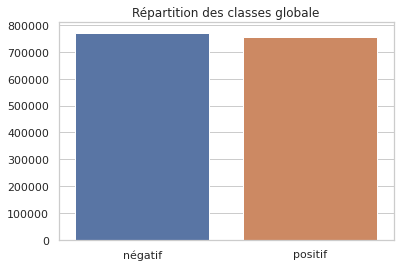

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=pd.DataFrame.from_dict([{polarity_dict[i]:etendue_classes[i] for i in range(len(etendue_classes))}])
).set(title='Répartition des classes globale')


Classes équilibrées

## Vectorisation

In [ ]:
ALL_STOP_WORDS = FRENCH_STOP_WORDS.union(fr_stopwords.stopwords('fr'))

In [ ]:
ALL_STOP_WORDS

In [ ]:
from spacy.lang.fr import French

In [ ]:
nlp = spacy.load("fr_core_news_sm")
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7fa153d79550>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7fa153d9f210>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7fa153d9f130>)]

In [ ]:
tokenizer = lambda x: [token.text for token in nlp.tokenizer(x) if len(token)>2 and not token.is_punct]

In [ ]:
vectorizer = TfidfVectorizer(
    stop_words = ALL_STOP_WORDS,
    tokenizer = tokenizer,
    min_df = 5,
    max_df = 0.8
)

In [ ]:
X_tdf = vectorizer.fit_transform(df_labeled['text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["quelqu'"] not in stop_words.
  % sorted(inconsistent)


In [ ]:
vocab_tdf = vectorizer.get_feature_names_out()

In [ ]:
X_tdf.shape

(1526724, 52126)

## Séparation en apprentissage/test

In [ ]:
X_tdf_train, X_tdf_test, y_train, y_test = train_test_split(
    X_tdf,
    df_labeled['label'],
    test_size=0.33
)

In [ ]:
X_tdf_train.shape

(1022905, 52126)

In [ ]:
X_tdf_test.shape

(503819, 52126)

In [ ]:
etendue_classes_app = y_train.value_counts()

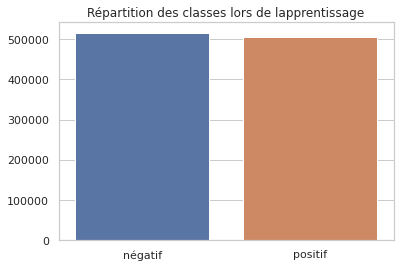

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=pd.DataFrame.from_dict([{polarity_dict[i]:etendue_classes_app[i] for i in range(len(etendue_classes))}])
).set(title='Répartition des classes lors de lapprentissage')

In [ ]:
etendue_classes_test = y_test.value_counts()

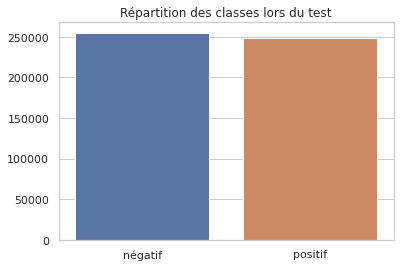

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=pd.DataFrame.from_dict([{polarity_dict[i]:etendue_classes_test[i] for i in range(len(etendue_classes))}])
).set(title='Répartition des classes lors du test')

On garde également un nombre équilibré d'individus entre les deux classes lors de l'apprentissage et du test

In [ ]:
from sklearn import metrics

def calculMetriques(true_labels, computed_labels):
  '''Renvoie un dataframe contenant différentes mesures de performances du modèle
  true_labels : labels réels
  computed_labels : labels calculés
  '''
  results = {}

  clustering_metrics = {
        "Accuracy": metrics.accuracy_score, 
        "Recall" : metrics.recall_score,
        "Precision": metrics.precision_score,
        "F1-Score": metrics.f1_score,
        "AUC": metrics.roc_auc_score
  }

  for k, v in clustering_metrics.items():
    results[k] = float("{0:.2f}".format(v(true_labels, computed_labels)))

  return (pd.DataFrame.from_dict([results]))

## Naïve Bayes Classifier

In [ ]:
NB_classifier = MultinomialNB()
t0 = time.time()
NB_classifier.fit(X_tdf_train, y_train)
t1 = time.time()

In [ ]:
predicted_NB = NB_classifier.predict(X_tdf_test)
t2 = time.time()

In [ ]:
print(12*"=")
print("Fitting time : " + str(t1-t0) + 's')
print("Predicting time : " + str(t2-t1) + 's')
print(12*"=")

Fitting time : 0.2853274345397949s
Predicting time : 1.712040662765503s


In [ ]:
NB_conf_matrix = metrics.confusion_matrix(y_test, predicted_NB)

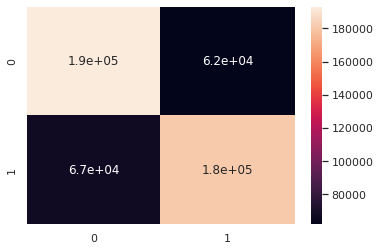

In [ ]:
sns.heatmap(NB_conf_matrix, annot=True)

In [ ]:
calculMetriques(y_test, predicted_NB)

,Accuracy,Recall,Precision,F1-Score,AUC
0,0.74,0.73,0.75,0.74,0.74


## Logistic Regression

In [ ]:
lr = LogisticRegression(solver = 'sag', random_state = 42, max_iter=3000)

In [ ]:
t0 = time.time()
lr.fit(X_tdf_train, y_train)
t1 = time.time()

In [ ]:
lr_y_pred = lr.predict(X_tdf_test)
t2 = time.time()

In [ ]:
print(12*"=")
print("Fitting time : " + str(t1-t0) + 's')
print("Predicting time : " + str(t2-t1) + 's')
print(12*"=")

Fitting time : 19.78775429725647s
Predicting time : 3.148972272872925s


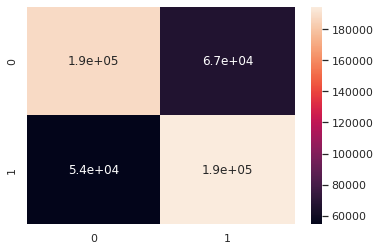

In [ ]:
NB_conf_matrix = metrics.confusion_matrix(y_test, lr_y_pred)
sns.heatmap(NB_conf_matrix, annot=True)

In [ ]:
calculMetriques(y_test, lr_y_pred)

,Accuracy,Recall,Precision,F1-Score,AUC
0,0.76,0.78,0.74,0.76,0.76


## Random Forest Classifier

In [ ]:
RF_classifier = RandomForestClassifier()
t0 = time.time()
RF_classifier.fit(X_tdf_train, y_train)
t1 = time.time()

In [ ]:
predicted_RF = RF_classifier.predict(X_tdf_test)
t2 = time.time()

## Support Vector Classifier

In [ ]:
SV_classifier = svm.SVC(kernel='linear')

In [ ]:
t0 = time.time()
SV_classifier.fit(X_tdf_train, y_train)
t1 = time.time()

In [ ]:
predicted_SV = SV_classifier.predict(X_tdf_test)
t2 = time.time()

## K-Means

In [ ]:
t0 = time.time()
KMS = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(X_tdf_train)
t1 = time.time()

In [ ]:
lbls = KMS.predict(X_tdf_test)
t2 = time.time()

In [ ]:
print(12*"=")
print("Fitting time : " + str(t1-t0) + 's')
print("Predicting time : " + str(t2-t1) + 's')
print(12*"=")

Fitting time : 34.90686392784119s
Predicting time : 2.0401418209075928s


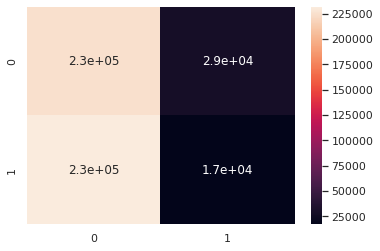

In [ ]:
NB_conf_matrix = metrics.confusion_matrix(y_test, lbls)
sns.heatmap(NB_conf_matrix, annot=True)

In [ ]:
calculMetriques(y_test, lbls)

,Accuracy,Recall,Precision,F1-Score,AUC
0,0.48,0.07,0.37,0.12,0.48


## Sauvegarde des modèles

In [ ]:
MODELES_FOLDER = RESSOURCES_FOLDER+'Modeles/'

In [ ]:
# On sauvegarde les idf
pickle.dump(vocab_tdf ,open(MODELES_FOLDER+"tfidf.sav","wb"))

In [ ]:
pickle.dump(NB_classifier, open(MODELES_FOLDER+'Naive_Bayes_Model.sav', 'wb'))

In [ ]:
pickle.dump(lr, open(MODELES_FOLDER+'Logistic_Regression_Model.sav', 'wb'))

In [ ]:
pickle.dump(RF_classifier, open(MODELES_FOLDER+'Random_Forest_Model.sav', 'wb'))

In [ ]:
pickle.dump(SV_classifier, open(MODELES_FOLDER+'SVM_Model.sav', 'wb'))

In [ ]:
pickle.dump(KMS, open(MODELES_FOLDER+'KMeans_Model.sav', 'wb'))

# Cas d'utilisation : Prédiction sur nos données

In [ ]:
transformer = TfidfTransformer()

In [ ]:
loaded_vec = CountVectorizer(vocabulary=pickle.load(open(MODELES_FOLDER+"tfidf.sav", "rb")))

In [ ]:
X_unlabeled_tdf = transformer.fit_transform(loaded_vec.fit_transform(df_unlabeled['tweet']))

In [ ]:
X_unlabeled_tdf.shape

(1939, 52126)

In [ ]:
pred_lr = lr.predict(X_unlabeled_tdf)

In [ ]:
etendue_classes_pred = pd.DataFrame(pred_lr).value_counts()

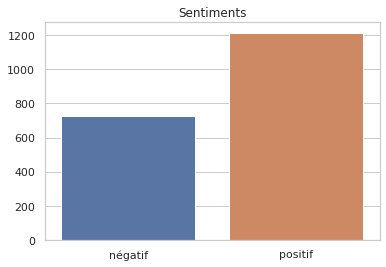

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=pd.DataFrame.from_dict([{polarity_dict[i]:etendue_classes_pred[i] for i in range(len(polarity_dict))}])
).set(title='Sentiments')